In [1]:
#Gas-phase calculations

#Unit cell obtained from https://materialsproject.org/materials/mp-48/

#Converted into mol file in openbabel and then minimized and then converted to .xyz using the same.

import psi4

psi4.set_memory(4250000000)
psi4.set_num_threads(4)

molecule = psi4.geometry(""" 0 1
 C          0.00000        0.00000        2.17130
C         -1.23390        2.13710        2.17130
C          2.46770        0.00000        2.17130
C          1.23390        2.13710        2.17130
C          0.00000        0.00000        6.51380
C         -1.23390        2.13710        6.51380
C          2.46770        0.00000        6.51380
C          1.23390        2.13710        6.51380
C          1.23390        0.71240        2.17130
C          0.00000        1.42470        6.51380
C          0.00000       -1.42470        2.17130
C         -1.23390        0.71240        2.17130
C         -2.46770        2.84950        2.17130
C          0.00000        2.84950        2.17130
C          2.46770       -1.42470        2.17130
C          3.70160        0.71240        2.17130
C          2.46770        2.84950        2.17130
C         -1.23390       -0.71240        6.51380
C          1.23390       -0.71240        6.51380
C         -2.46770        1.42470        6.51380
C         -1.23390        3.56190        6.51380
C          3.70160       -0.71240        6.51380
C          2.46770        1.42470        6.51380
C          1.23390        3.56190        6.51380

""", name= "Graphite Nanotube Primitive Cell")


psi4.set_options({
 "save_jk" : True,
})

e, wfn = psi4.energy("B3LYP/aug-cc-pVDZ", return_wfn=True, molecule=molecule)


  Memory set to   3.958 GiB by Python driver.
  Threads set to 4 by Python driver.

Scratch directory: /tmp/

*** tstart() called on Bedabratas-MacBook-Air.local
*** at Fri Jul 22 10:29:38 2022

   => Loading Basis Set <=

    Name: AUG-CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-24 entry C          line   182 file /opt/miniconda3/share/psi4/basis/aug-cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RKS Reference
                        4 Threads,   4053 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C1

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    -----

/opt/miniconda3/lib//python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


   @DF-RKS iter   1:  -911.26167161958620   -1.07522e+00   2.75994e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -893.71429975139358    1.75474e+01   9.72497e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -912.16046731234178   -1.84462e+01   1.45391e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -905.88214077987095    6.27833e+00   4.72731e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -912.40084759842171   -6.51871e+00   1.05352e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -912.56352485904711   -1.62677e-01   5.65207e-04 ADIIS/DIIS
   @DF-RKS iter   7:  -912.60820682534700   -4.46820e-02   4.25572e-04 ADIIS/DIIS
   @DF-RKS iter   8:  -912.64450704233570   -3.63002e-02   1.37297e-04 ADIIS/DIIS
   @DF-RKS iter   9:  -912.64541494508512   -9.07903e-04   1.17874e-04 ADIIS/DIIS
   @DF-RKS iter  10:  -912.64623960715085   -8.24662e-04   9.94134e-05 DIIS
   @DF-RKS iter  11:  -912.64827097616683   -2.03137e-03   5.38965e-06 DIIS
   @DF-RKS iter  12:  -912.64824700850659    2.39677e-05   1.22142e-05 DIIS
   @DF-RKS iter  13:  -912.6482773

In [42]:
HOMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha()-1]
LUMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha()]
print(HOMO, LUMO, e)

-0.25211292946877456 -0.21351840794112623 -912.6482812045049


In [43]:
#Dipole Moment Calculation

psi4.oeprop(wfn, 'DIPOLE', title='H3O+ SCF')



Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the H3O+ SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0008033            0.0000000            0.0008033
 Dipole Y            :         -0.0002633            0.0000000           -0.0002633
 Dipole Z            :         -0.0000281           -0.0000000           -0.0000281
 Magnitude           :                                                    0.0008458

 ------------------------------------------------------------------------------------


In [11]:
2.54174645190*0.0008458

0.00214980914901702

In [44]:
band_gap=(LUMO-HOMO)*27.2114 

print(band_gap)

1.0502109630974499


In [13]:
#Estimate nanoparticle volume and calculate radius of nanoparticle assuming it's enclosed in a sphere

import deepchem
import numpy as np

#from https://github.com/deepchem/deepchem/blob/master/deepchem/utils/rdkit_utils.py

import os
import logging
import itertools
import numpy as np
from io import StringIO
from deepchem.utils.pdbqt_utils import pdbqt_to_pdb
from deepchem.utils.pdbqt_utils import convert_mol_to_pdbqt
from deepchem.utils.pdbqt_utils import convert_protein_to_pdbqt
from deepchem.utils.geometry_utils import compute_pairwise_distances
from deepchem.utils.geometry_utils import compute_centroid
from deepchem.utils.fragment_utils import MolecularFragment
from deepchem.utils.fragment_utils import MoleculeLoadException
from typing import Any, List, Tuple, Set, Optional, Dict
from deepchem.utils.typing import OneOrMany, RDKitMol

logger = logging.getLogger(__name__)


def get_xyz_from_mol(mol):
  """Extracts a numpy array of coordinates from a molecules.
  Returns a `(N, 3)` numpy array of 3d coords of given rdkit molecule
  Parameters
  ----------
  mol: rdkit Molecule
    Molecule to extract coordinates for
  Returns
  -------
  Numpy ndarray of shape `(N, 3)` where `N = mol.GetNumAtoms()`.
  """
  xyz = np.zeros((mol.GetNumAtoms(), 3))
  conf = mol.GetConformer()
  for i in range(conf.GetNumAtoms()):
    position = conf.GetAtomPosition(i)
    xyz[i, 0] = position.x
    xyz[i, 1] = position.y
    xyz[i, 2] = position.z
  return (xyz)

import rdkit
from rdkit import Chem


#Crystal imported from Avogadro software and converted to mol file with OpenBabel

m= Chem.MolFromMolFile('graphene.mol')

coords= get_xyz_from_mol(m)

from scipy.spatial import ConvexHull

hull = ConvexHull(coords)


cell_volume = hull.volume #This is in cubic Angstroms
radius_0=(3/4*(cell_volume/np.pi))**(1/3)

In [14]:
radius_0

2.7165472617897435

Text(0, 0.5, 'Band-Gap(eV)')

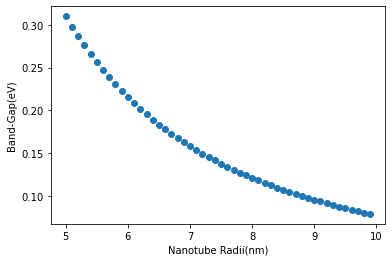

In [32]:
# From the paper Electron-electron and electron-hole interactions in small semiconductor crystallites : The size dependence of the lowest excited electronic state
#Bamd gap/HOMO-LUMO gap varies as 1/R^2 with the nanoparticle radius

#http://fizyka.umk.pl/~wj/EDU/Pracownia_Projektowa/brus.pdf


def gap_as_a_function_of_radius(R):
    
    res=((band_gap)*(radius_0)**2)/(R**2)      #converting gap to electron volts
    return res


import matplotlib.pyplot as plt

radii=np.arange(5,10,.1)     #graphene unit cell is 0.246 nm
gaps=[gap_as_a_function_of_radius(R) for R in radii]
plt.scatter(radii,gaps)
plt.xlabel("Nanotube Radii(nm)")
plt.ylabel("Band-Gap(eV)")

In [16]:
gap_as_a_function_of_radius(0.5) 

31.000669224845918

In [17]:
#Load Hydration Free Energy Model
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import sklearn
import joblib

loaded_model = joblib.load('dielectric_new.sav')

In [18]:
#Needs better data

def dielectric_constant_solute(R):
    return loaded_model.predict(np.array([gap_as_a_function_of_radius(R)]).reshape(-1,1))[0]

In [19]:
dielectric_constant_solute(0.5)

3.426200000000002

Text(0, 0.5, 'Dielectric Constant')

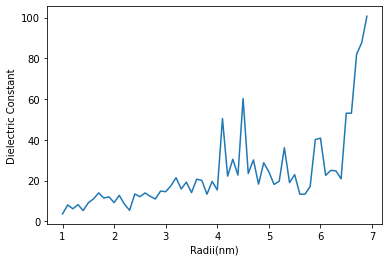

In [38]:
radii=np.arange(1,7,.1)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[dielectric_constant_solute(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Dielectric Constant")

In [27]:
#Calculate ground-state exciton energy as a function of nanoparticle radii

def exciton_energy(R):
    eps_0=8.854*(10**(-12))
    coulomb_interaction=(1.8*(1.60217663*(10**(-19)))**2)/((R*(10**(-9)))*(eps_0*dielectric_constant_solute(R)))                
    coul_ev=(coulomb_interaction)*(6.242*(10**18))
    res=gap_as_a_function_of_radius(R)-coul_ev
    return res

In [31]:
exciton_energy(5.5)

-0.002380066060821473

Text(0, 0.5, 'Exciton Energies(eV)')

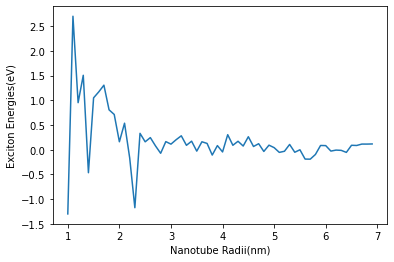

In [39]:
import matplotlib.pyplot as plt

radii=np.arange(1,7,.1)     
gaps=[exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Nanotube Radii(nm)")
plt.ylabel("Exciton Energies(eV)")

Text(0, 0.5, 'gap-exciton differences(eV)')

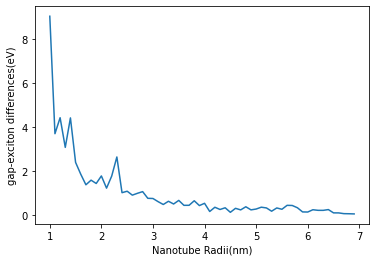

In [41]:
import matplotlib.pyplot as plt

radii=np.arange(1,7,0.1)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[gap_as_a_function_of_radius(R)-exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Nanotube Radii(nm)")
plt.ylabel("gap-exciton differences(eV)")

In [157]:
gap_as_a_function_of_radius(0.4)-exciton_energy(0.4)

6.353332190828234